<a href="https://colab.research.google.com/github/sarvesh23110076/CS203_Assign_6/blob/main/CS203_Assign_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<B>CS203 : Software Tools and Techniques fo AI </B><br>
<B>LAB6 Assignment</B><br>

---


<B>Group Number : 08<Br>
<B>Group Members :</B><br>
<B>Sarvesh Pravin Chaudhari (<I>23110076</I>)<br>
Afraz Azeem (<I>23110019</I>)<B>

<B>Section 1: MLP Model Implementation & Experiment Tracking</B>

<B><I>1. Implement a Multi-Layer Perceptron (MLP) Using the Iris Dataset (05%)</I></B>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

Load the Iris dataset using sklearn.datasets.load_iris

In [ ]:
dataset=sklearn.datasets.load_iris()

Extract features and labels, ensuring labels are one-hot encoded.

In [ ]:
X=dataset['data']
y=dataset['target']
names=dataset['target_names']

Split the dataset into:
Training set: 70%
Validation set: 10%
Testing set: 20%.


In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=32)
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=0.125,random_state=32)

X_train.shape,X_valid.shape,X_test.shape

((105, 4), (15, 4), (30, 4))

Normalize feature values to [0,1] using standard scaling.

In [ ]:
from sklearn import preprocessing

def preprocessing_data(data):
  scaling_model=preprocessing.StandardScaler()
  scaling_model=scaling_model.fit(data)
  return scaling_model.transform(data)

X_train=preprocessing_data(X_train)
X_valid=preprocessing_data(X_valid)
X_test=preprocessing_data(X_test)

X_train,y_train=torch.tensor(X_train).float(),torch.tensor(y_train).long()
X_valid,y_valid=torch.tensor(X_valid).float(),torch.tensor(y_valid).long()
X_test,y_test=torch.tensor(X_test).float(),torch.tensor(y_test).long()

<B><I>2. Define and Train the MLP Model (05%)</I></B>


Construct a Multi-Layer Perceptron (MLP) model with the following architecture:<br>
- Input layer: 4 neurons (for 4 features).<br>
- Hidden layer: 16 neurons, ReLU activation.<br>
- Output layer: 3 neurons (for each class), softmax activation.


In [ ]:
class MLP(torch.nn.Module):
  def __init__(self,infeatures,outfeatures):
    super(MLP,self).__init__()
    self.layer1=torch.nn.Sequential(
        torch.nn.Linear(in_features=infeatures,out_features=16),
        torch.nn.ReLU()
    )
    self.layer2=torch.nn.Sequential(
        torch.nn.Linear(in_features=16,out_features=outfeatures),
        torch.nn.Softmax(dim=1)
    )
  def forward(self,x):
    x=self.layer1(x)
    x=self.layer2(x)
    return x

In [ ]:
number_of_features=X_train.shape[1]
number_of_classes=len(dataset['target_names'])

model=MLP(number_of_features,number_of_classes)
model

MLP(
  (layer1): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=16, out_features=3, bias=True)
    (1): Softmax(dim=1)
  )
)

Train using:<br>
Loss function: Categorical cross-entropy.<br>
Optimizer: Adam.<br>
Learning rate: 0.001.<br>
Batch size: 32.<br>
Epochs: 50.<br>

In [ ]:
from torch.utils.data import TensorDataset,DataLoader

def train(model,train_dataset,valid_dataset,epochs,lr,batchsize):
  criterion=torch.nn.CrossEntropyLoss()
  optimizer=torch.optim.Adam(model.parameters(),lr=lr)
  train_loader=DataLoader(train_dataset,batch_size=batchsize,shuffle=True)
  valid_loader=DataLoader(valid_dataset,batch_size=batchsize,shuffle=True)

  loss_train=[]
  loss_valid=[]

  for epoch in range(epochs):
    model.train()
    trainloss=0
    for X_features,y_labels in train_loader:
      X_features = X_features.requires_grad_()
      optimizer.zero_grad()
      output=model(X_features)
      loss=criterion(output,y_labels)
      loss.backward()
      optimizer.step()
      trainloss+=loss.item()
    loss_train.append(trainloss/len(train_loader))

    model.eval()
    validloss=0
    with torch.no_grad():
      for X_features,y_labels in valid_loader:
        output=model(X_features)
        loss=criterion(output,y_labels)
        validloss+=loss.item()
      loss_valid.append(validloss/len(valid_loader))

  return model,loss_train,loss_valid

Track and store both training and validation loss during training.

In [ ]:
model,train_loss,valid_loss=train(model,TensorDataset(X_train,y_train),TensorDataset(X_valid,y_valid),500,0.001,32)

model.eval()
with torch.no_grad():
  output=model(X_test)
  _,predict=torch.max(output,axis=1)

<I><B>3. Evaluate Model Performance (10%)</I></B><br>

Compute and store the following metrics using the test set:<br>
- Accuracy<br>
- Precision<br>
- Recall<br>
- F1-score<br>
- Confusion matrix (visualized using Matplotlib).


In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import pandas as pd

def metrics_data(truth,prediction):
  accuracy=accuracy_score(y_pred=prediction,y_true=truth)
  precision=precision_score(y_pred=prediction,y_true=truth,average='weighted')
  recall=recall_score(y_pred=prediction,y_true=truth,average='weighted')
  f1_score_value=f1_score(y_pred=prediction,y_true=truth,average='weighted')
  return [accuracy,precision,recall,f1_score_value]

metrics=metrics_data(y_test,predict)
labels=['Accuracy','Precision','Recall','F1-score']
dic={
    'Metrics':labels,
    'Values':metrics
}
data=pd.DataFrame(dic).set_index('Metrics')
data

,Values
Metrics,
Accuracy,0.933333
Precision,0.945455
Recall,0.933333
F1-score,0.932500


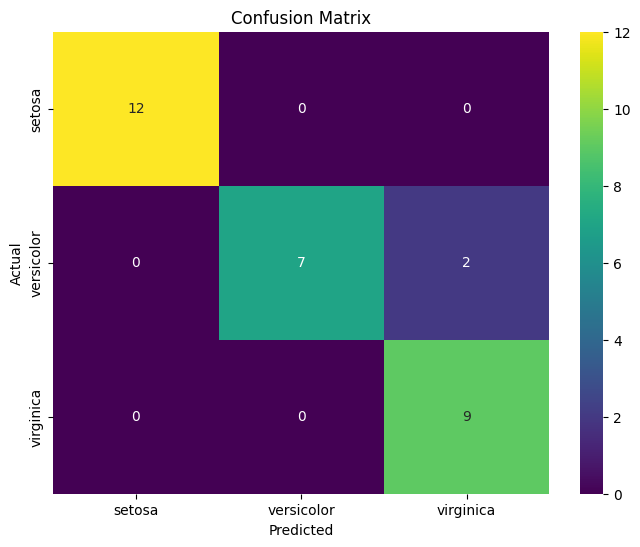

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(truth,prediction,class_names):
    cm = confusion_matrix(truth, prediction)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm,annot=True,fmt='d',cmap='viridis',xticklabels=class_names,yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test,predict,class_names=names)

Plot training and validation loss curves over epochs using Matplotlib.


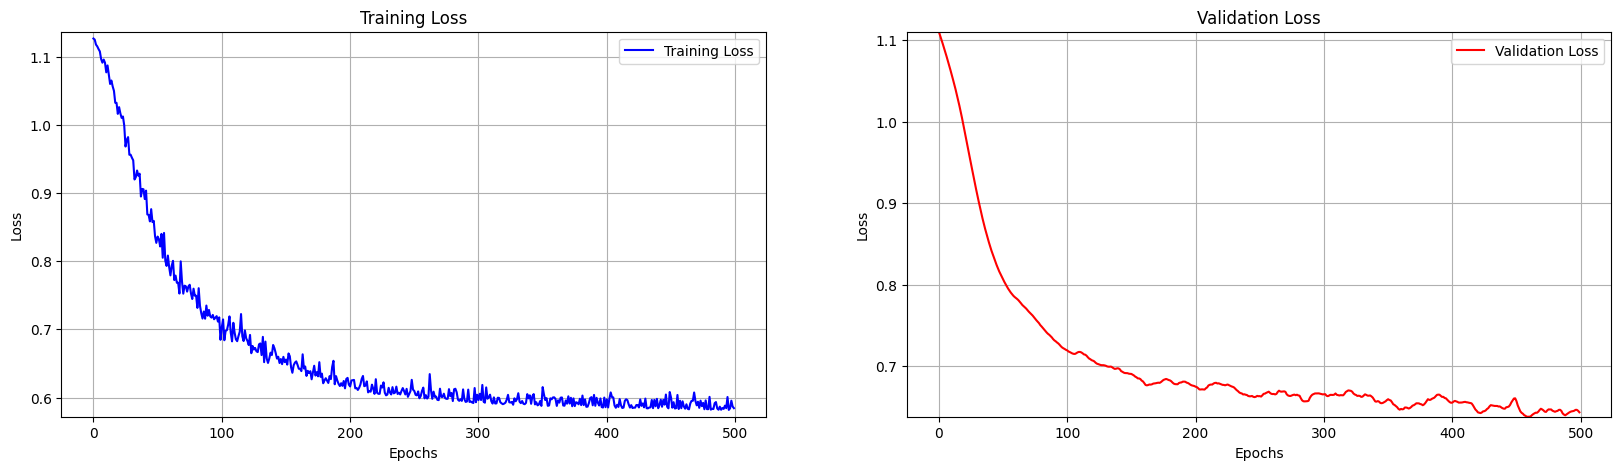

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x=np.arange(0,500)
train_loss=np.array(train_loss)
valid_loss=np.array(valid_loss)

fig,axs=plt.subplots(1,2,figsize=(20,5))  # Two subplots (2 rows, 1 column)

# Plot training loss
axs[0].plot(x,train_loss,label='Training Loss',color='blue')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim(ymin=train_loss[np.argmin(train_loss)]-0.01,ymax=train_loss[np.argmax(train_loss)]+0.01)
axs[0].legend()
axs[0].grid()

# Plot validation loss
axs[1].plot(x,valid_loss,label='Validation Loss',color='red')
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_ylim(ymin=valid_loss[np.argmin(valid_loss)]-(1e-6),ymax=valid_loss[np.argmax(valid_loss)]+(1e-6))
axs[1].legend()
axs[1].grid()
plt.show()




<I><B>4. Set Up Experiment Tracking with Weights & Biases (W&B) (30 %)


In [ ]:
! pip install wandb

Log the following details:<br>
- Model architecture: Number of layers, neurons, activation functions.
- Hyperparameters: Learning rate, batch size, number of epochs.
- Training and validation loss per epoch.
- Final evaluation metrics.
- Confusion matrix and loss curve visualizations.


In [ ]:
import wandb
import time
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

wandb.init(project="CS203_Assign_6",name="MLP_Training")

config={
    "learning_rate":0.001,
    "epochs":50,
    "batch_size":32,
    "optimizer":"Adam"
}
wandb.config.update(config)


def train_logging(model,train_dataset,valid_dataset,config):
  criterion=torch.nn.CrossEntropyLoss()
  optimizer=torch.optim.Adam(model.parameters(),lr=config["learning_rate"])
  train_loader=DataLoader(train_dataset,batch_size=config["batch_size"],shuffle=True)
  valid_loader=DataLoader(valid_dataset,batch_size=config["batch_size"],shuffle=True)
  train_losses,val_losses=[],[]

  for epoch in range(config["epochs"]):
    model.train()
    running_loss=0.0

    for i,(X_features,y_labels) in enumerate(train_loader):
      X_features = X_features.requires_grad_()
      optimizer.zero_grad()
      output=model(X_features)
      loss=criterion(output,y_labels)
      loss.backward()
      optimizer.step()

      wandb.log({"loss":loss.item(),"iteration":epoch*len(train_loader),"learning_rate":optimizer.param_groups[0]['lr']})

      running_loss += loss.item()
      if i % 2 == 0:
          print(f"Epoch {epoch+1}, Iter {i+1}, Loss: {running_loss / 100:.4f}")
          running_loss = 0.0

    train_losses.append(running_loss/len(train_loader))

    model.eval()
    val_loss=0.0
    correct=[]
    predicts=[]

    with torch.no_grad():
      for X_features,y_labels in valid_loader:
        output=model(X_features)
        loss=criterion(output,y_labels)
        val_loss+=loss.item()
        _,predict=torch.max(output,1)
        correct.extend(y_labels.tolist())
        predicts.extend(predict.tolist())


    val_acc = accuracy_score(correct,predicts)
    val_losses.append(val_loss/len(valid_loader))

    wandb.log({"val_accuracy": val_acc, "val_loss":val_losses[-1]})
    print(f"Epoch {epoch+1}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_acc:.4f}")

  return model,train_losses,val_losses

number_of_features=X_train.shape[1]
number_of_classes=len(dataset['target_names'])

model=MLP(number_of_features,number_of_classes)

wandb.summary["model_architecture"]=str(model)
wandb.watch(model,log='all',log_freq=10)

model_table = wandb.Table(columns=["Layer", "Output Shape", "Parameters"])

for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Linear):
        model_table.add_data(name, f"{layer.out_features}", f"{layer.weight.numel() + layer.bias.numel()}")

wandb.log({"model_architecture_table": model_table})

start_time=time.time()
model, train_losses, val_losses=train_logging(model,TensorDataset(X_train,y_train),TensorDataset(X_valid,y_valid),config)
end_time=time.time()

model.eval()
with torch.no_grad():
  output=model(X_test)
  _,y_pred=torch.max(output,axis=1)

y_true=y_test

print(f"Training Completed in {end_time - start_time:.2f} seconds")

# Compute Final Evaluation Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

# Print Final Evaluation Metrics
print("\nFinal Evaluation Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Log Final Evaluation Metrics to W&B
# Log final metrics to W&B summary
wandb.summary["Final Accuracy"] = accuracy
wandb.summary["Final Precision"] = precision
wandb.summary["Final Recall"] = recall
wandb.summary["Final F1 Score"] = f1
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Log Confusion Matrix to W&B
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.close()

# Plot Loss Curve
fig,axes=plt.subplots(2,1,figsize=(20, 5))
axes[0].plot(range(1, config["epochs"] + 1), train_losses, label="Train Loss", marker="o")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].set_title("Training Loss Curve")

axes[1].plot(range(1, config["epochs"] + 1), val_losses, label="Validation Loss", marker="s")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].set_title("Validation Loss Curve")

# Log Loss Curve to W&B
wandb.log({"loss_curve": wandb.Image(plt)})
plt.close()

wandb.finish()

Epoch 1, Iter 1, Loss: 0.0113
Epoch 1, Iter 3, Loss: 0.0229
Epoch 1, Training Loss: 0.2721, Validation Loss: 1.1439, Validation Accuracy: 0.3333
Epoch 2, Iter 1, Loss: 0.0114
Epoch 2, Iter 3, Loss: 0.0226
Epoch 2, Training Loss: 0.2800, Validation Loss: 1.1404, Validation Accuracy: 0.3333
Epoch 3, Iter 1, Loss: 0.0113
Epoch 3, Iter 3, Loss: 0.0225
Epoch 3, Training Loss: 0.2835, Validation Loss: 1.1370, Validation Accuracy: 0.3333
Epoch 4, Iter 1, Loss: 0.0110
Epoch 4, Iter 3, Loss: 0.0227
Epoch 4, Training Loss: 0.2782, Validation Loss: 1.1333, Validation Accuracy: 0.3333
Epoch 5, Iter 1, Loss: 0.0113
Epoch 5, Iter 3, Loss: 0.0223
Epoch 5, Training Loss: 0.2739, Validation Loss: 1.1297, Validation Accuracy: 0.3333
Epoch 6, Iter 1, Loss: 0.0112
Epoch 6, Iter 3, Loss: 0.0221
Epoch 6, Training Loss: 0.2855, Validation Loss: 1.1260, Validation Accuracy: 0.3333
Epoch 7, Iter 1, Loss: 0.0111
Epoch 7, Iter 3, Loss: 0.0220
Epoch 7, Training Loss: 0.2857, Validation Loss: 1.1224, Validation Ac

iteration,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,████▇▇▇▇█▇▇▇▇▇▆▆▆▆▅▆▅▆▅▅▄▅▅▄▄▄▃▄▃▃▃▃▂▂▁▄
val_accuracy,▁▁▁▁▁▁▁▁▃▃▂▃▂▂▂▄▄▄▄▄▄▆▆▇▇███████████████
val_loss,██████▇▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
Final Accuracy,0.86667
Final F1 Score,0.85974
Final Precision,0.90769
Final Recall,0.86667
iteration,196
learning_rate,0.001


**Section 2: Hyperparameters**

1. **Hyperparameter Optimization (20%)**

In [ ]:
test_dataset = TensorDataset(X_test,y_test)
def test_samples(model, test_dataset, num_samples=5):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
    samples = []

    with torch.no_grad():
        for i, (X_features, y_labels) in enumerate(test_loader):
            if i >= num_samples:
                break

            output = model(X_features)
            _, predicted = torch.max(output, 1)

            samples.append({
                'input': X_features.squeeze().tolist(),
                'prediction': predicted.item(),
                'truth': y_labels.item()
            })

    return samples


1.1) For batch size=2, learning rate=0.001, epochs=1

In [ ]:
number_of_features=X_train.shape[1]
number_of_classes=len(dataset['target_names'])

model=MLP(number_of_features,number_of_classes)
model,train_loss,valid_loss=train(model,TensorDataset(X_train,y_train),TensorDataset(X_valid,y_valid),1,0.001,2)

In [ ]:
model.eval()
with torch.no_grad():
  output=model(X_test)
  _,predict=torch.max(output,axis=1)

In [ ]:
metrics=metrics_data(y_test,predict)
labels=['Accuracy','Precision','Recall','F1-score']
dic={
    'Metrics':labels,
    'Values':metrics
}
data=pd.DataFrame(dic).set_index('Metrics')
data

,Values
Metrics,
Accuracy,0.533333
Precision,0.648128
Recall,0.533333
F1-score,0.507367


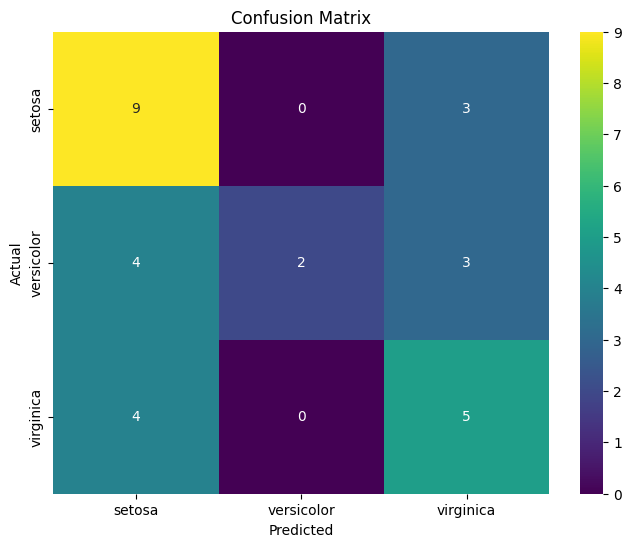

In [ ]:
plot_confusion_matrix(y_test,predict,class_names=names)

In [ ]:
test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(y_test))
sample_results = test_samples(model, test_dataset, 5)
for i, sample in enumerate(sample_results):
    print(f"Sample {i+1}:")
    print(f"Input: {sample['input']}")
    print(f"Prediction: {names[sample['prediction']]}")
    print(f"Truth: {names[sample['truth']]}")
    print()

Sample 1:
Input: [-1.3882484436035156, 1.0772606134414673, -1.4111891984939575, -1.198310136795044]
Prediction: setosa
Truth: setosa

Sample 2:
Input: [1.2303040027618408, -0.052733033895492554, 1.1750539541244507, 1.7861604690551758]
Prediction: virginica
Truth: virginica

Sample 3:
Input: [-1.1388624906539917, -0.2787317633628845, -1.1862984895706177, -1.333967924118042]
Prediction: virginica
Truth: setosa

Sample 4:
Input: [2.7266197204589844, 1.5292580127716064, 1.6248352527618408, 1.2435294389724731]
Prediction: virginica
Truth: virginica

Sample 5:
Input: [-0.14131870865821838, -1.408725380897522, 0.21926842629909515, 0.02260962501168251]
Prediction: versicolor
Truth: versicolor



<ipython-input-36-4e921072bdc2>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(y_test))


In [ ]:
def evaluate_model_comprehensive(model, X_test, y_test, names, num_samples=5):
    model.eval()
    with torch.no_grad():
        output = model(X_test)
        _, predict = torch.max(output, axis=1)

    # Compute and display metrics
    metrics = metrics_data(y_test, predict)
    labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    dic = {
        'Metrics': labels,
        'Values': metrics
    }
    data = pd.DataFrame(dic).set_index('Metrics')
    print(data)
    print("\n----------------------------------------------------------------------------\n")

    # Plot confusion matrix
    plot_confusion_matrix(y_test, predict, class_names=names)
    print("\n----------------------------------------------------------------------------\n")

    # Show sample predictions
    test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(y_test))
    sample_results = test_samples(model, test_dataset, num_samples)
    for i, sample in enumerate(sample_results):
        print(f"Sample {i+1}:")
        print(f"Input: {sample['input']}")
        print(f"Prediction: {names[sample['prediction']]}")
        print(f"Truth: {names[sample['truth']]}")
        print()

1.2) For batch size=2, learning rate=0.001, epochs=3

           Values
Metrics          
Accuracy     0.70
Precision    0.55
Recall       0.70
F1-score     0.60

----------------------------------------------------------------------------



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


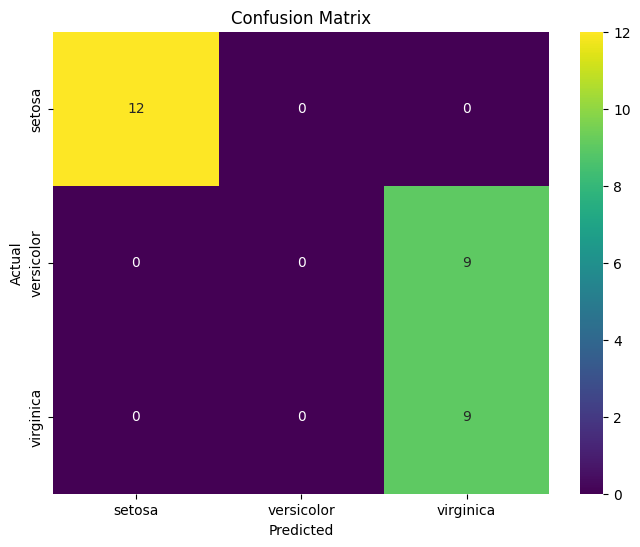


----------------------------------------------------------------------------

Sample 1:
Input: [-0.01662573032081127, -1.408725380897522, 0.8377178311347961, 1.2435294389724731]
Prediction: virginica
Truth: virginica

Sample 2:
Input: [-0.14131870865821838, -0.2787317633628845, 0.5566045045852661, 0.5652406215667725]
Prediction: virginica
Truth: versicolor

Sample 3:
Input: [-0.3907046616077423, 1.303259253501892, -1.1300758123397827, -1.198310136795044]
Prediction: setosa
Truth: setosa

Sample 4:
Input: [0.9809180498123169, -0.2787317633628845, 0.9501631855964661, 1.2435294389724731]
Prediction: virginica
Truth: virginica

Sample 5:
Input: [-1.0141695737838745, -0.052733033895492554, -1.1300758123397827, -1.198310136795044]
Prediction: setosa
Truth: setosa



<ipython-input-37-9a652778d31a>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(y_test))


In [ ]:
number_of_features=X_train.shape[1]
number_of_classes=len(dataset['target_names'])

model=MLP(number_of_features,number_of_classes)
model,train_loss,valid_loss=train(model,TensorDataset(X_train,y_train),TensorDataset(X_valid,y_valid),3,0.001,2)

evaluate_model_comprehensive(model, X_test, y_test, names, num_samples=5)

1.3) For batch size=2, learning rate=0.001, epochs=5

           Values
Metrics          
Accuracy    0.800
Precision   0.880
Recall      0.800
F1-score    0.775

----------------------------------------------------------------------------



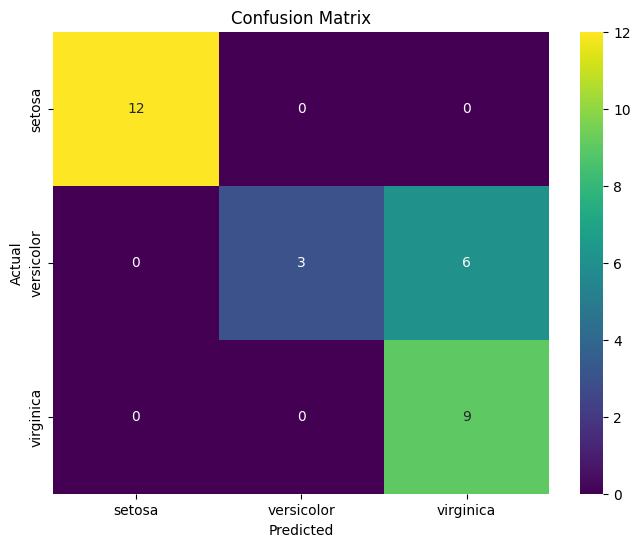


----------------------------------------------------------------------------

Sample 1:
Input: [0.731532096862793, -0.956727921962738, 0.7814951539039612, 0.9722139239311218]
Prediction: virginica
Truth: virginica

Sample 2:
Input: [-0.01662573032081127, -1.408725380897522, 0.8377178311347961, 1.2435294389724731]
Prediction: virginica
Truth: virginica

Sample 3:
Input: [-0.8894765377044678, 0.6252631545066833, -1.0738531351089478, -0.9269946813583374]
Prediction: setosa
Truth: setosa

Sample 4:
Input: [-0.14131870865821838, -0.2787317633628845, 0.5566045045852661, 0.5652406215667725]
Prediction: virginica
Truth: versicolor

Sample 5:
Input: [0.10806724429130554, -0.956727921962738, 0.33171379566192627, -0.11304812878370285]
Prediction: versicolor
Truth: versicolor



<ipython-input-37-9a652778d31a>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(y_test))


In [ ]:
number_of_features=X_train.shape[1]
number_of_classes=len(dataset['target_names'])

model=MLP(number_of_features,number_of_classes)
model,train_loss,valid_loss=train(model,TensorDataset(X_train,y_train),TensorDataset(X_valid,y_valid),5,0.001,2)

evaluate_model_comprehensive(model, X_test, y_test, names, num_samples=5)

1.4) For batch size=2, learning rate=0.00001, epochs=1

             Values
Metrics            
Accuracy   0.400000
Precision  0.165517
Recall     0.400000
F1-score   0.234146

----------------------------------------------------------------------------



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


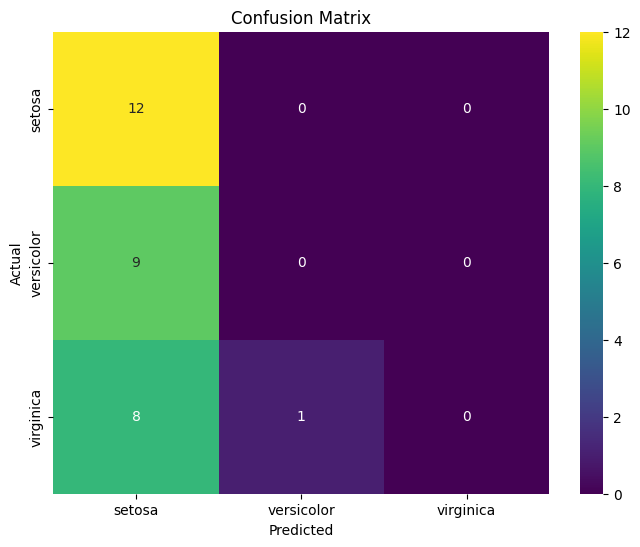


----------------------------------------------------------------------------

Sample 1:
Input: [-0.8894765377044678, -2.5387189388275146, -0.005622267723083496, -0.11304812878370285]
Prediction: setosa
Truth: versicolor

Sample 2:
Input: [-1.1388624906539917, -0.2787317633628845, -1.1862984895706177, -1.333967924118042]
Prediction: setosa
Truth: setosa

Sample 3:
Input: [-0.01662573032081127, -1.408725380897522, 0.8377178311347961, 1.2435294389724731]
Prediction: setosa
Truth: virginica

Sample 4:
Input: [-0.8894765377044678, 0.6252631545066833, -1.0738531351089478, -0.9269946813583374]
Prediction: setosa
Truth: setosa

Sample 5:
Input: [0.48214617371559143, -1.1827266216278076, 1.1750539541244507, 0.4295828938484192]
Prediction: versicolor
Truth: virginica



<ipython-input-37-9a652778d31a>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(y_test))


In [ ]:
number_of_features=X_train.shape[1]
number_of_classes=len(dataset['target_names'])

model=MLP(number_of_features,number_of_classes)
model,train_loss,valid_loss=train(model,TensorDataset(X_train,y_train),TensorDataset(X_valid,y_valid),1,0.00001,2)

evaluate_model_comprehensive(model, X_test, y_test, names, num_samples=5)

1.5) For batch size=2, learning rate=0.00001, epochs=3

             Values
Metrics            
Accuracy   0.200000
Precision  0.195000
Recall     0.200000
F1-score   0.194805

----------------------------------------------------------------------------



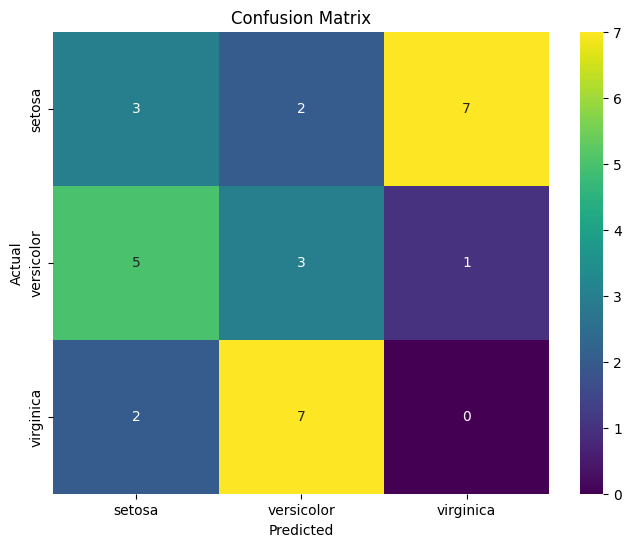


----------------------------------------------------------------------------

Sample 1:
Input: [0.35745319724082947, 0.6252631545066833, 0.5566045045852661, 0.7008984088897705]
Prediction: setosa
Truth: versicolor

Sample 2:
Input: [-0.3907046616077423, 1.303259253501892, -1.1300758123397827, -1.198310136795044]
Prediction: versicolor
Truth: setosa

Sample 3:
Input: [-0.7647835612297058, 1.5292580127716064, -0.9051850438117981, -0.9269946813583374]
Prediction: setosa
Truth: setosa

Sample 4:
Input: [-0.7647835612297058, 0.399264395236969, -1.0176304578781128, -0.7913368940353394]
Prediction: virginica
Truth: setosa

Sample 5:
Input: [0.731532096862793, 0.399264395236969, 0.669049859046936, 0.7008984088897705]
Prediction: setosa
Truth: versicolor



<ipython-input-37-9a652778d31a>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(y_test))


In [ ]:
number_of_features=X_train.shape[1]
number_of_classes=len(dataset['target_names'])

model=MLP(number_of_features,number_of_classes)
model,train_loss,valid_loss=train(model,TensorDataset(X_train,y_train),TensorDataset(X_valid,y_valid),3,0.00001,2)

evaluate_model_comprehensive(model, X_test, y_test, names, num_samples=5)

1.6) For batch size=2, learning rate=0.00001, epochs=5

             Values
Metrics            
Accuracy   0.266667
Precision  0.178462
Recall     0.266667
F1-score   0.213636

----------------------------------------------------------------------------



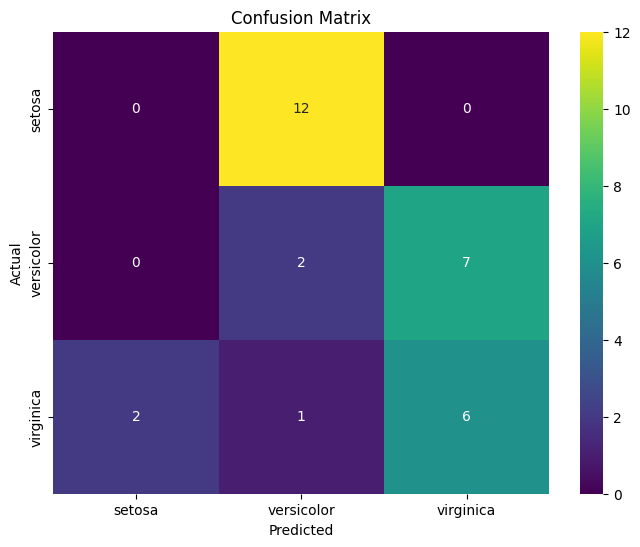


----------------------------------------------------------------------------

Sample 1:
Input: [-1.3882484436035156, 1.0772606134414673, -1.4111891984939575, -1.198310136795044]
Prediction: versicolor
Truth: setosa

Sample 2:
Input: [0.35745319724082947, 0.6252631545066833, 0.5566045045852661, 0.7008984088897705]
Prediction: virginica
Truth: versicolor

Sample 3:
Input: [-0.3907046616077423, 1.7552567720413208, -1.2425211668014526, -0.9269946813583374]
Prediction: versicolor
Truth: setosa

Sample 4:
Input: [-0.14131870865821838, -1.408725380897522, 0.21926842629909515, 0.02260962501168251]
Prediction: virginica
Truth: versicolor

Sample 5:
Input: [-1.7623274326324463, -0.2787317633628845, -1.3549665212631226, -1.333967924118042]
Prediction: versicolor
Truth: setosa



<ipython-input-37-9a652778d31a>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(y_test))


In [ ]:
number_of_features=X_train.shape[1]
number_of_classes=len(dataset['target_names'])

model=MLP(number_of_features,number_of_classes)
model,train_loss,valid_loss=train(model,TensorDataset(X_train,y_train),TensorDataset(X_valid,y_valid),5,0.00001,2)

evaluate_model_comprehensive(model, X_test, y_test, names, num_samples=5)

1.7) For batch size=4, learning rate=0.001, epochs=1

             Values
Metrics            
Accuracy   0.666667
Precision  0.480000
Recall     0.666667
F1-score   0.555556

----------------------------------------------------------------------------



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


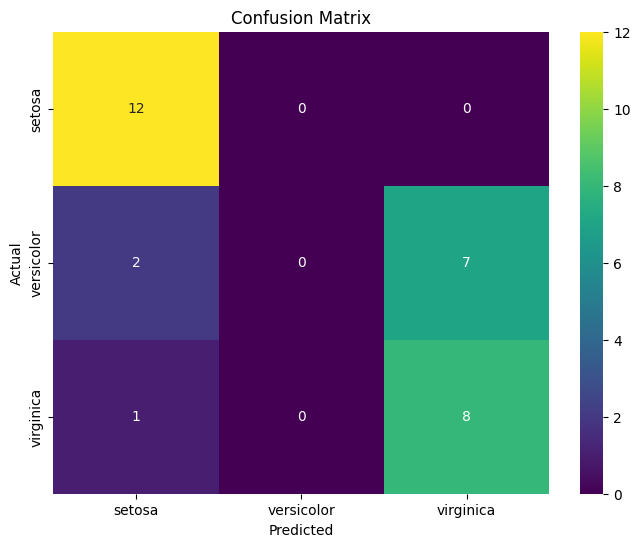


----------------------------------------------------------------------------

Sample 1:
Input: [-0.7647835612297058, 0.6252631545066833, -1.1300758123397827, -1.198310136795044]
Prediction: setosa
Truth: setosa

Sample 2:
Input: [-1.1388624906539917, -0.2787317633628845, -1.1862984895706177, -1.333967924118042]
Prediction: setosa
Truth: setosa

Sample 3:
Input: [0.731532096862793, -0.956727921962738, 0.7814951539039612, 0.9722139239311218]
Prediction: virginica
Truth: virginica

Sample 4:
Input: [-0.7647835612297058, 0.399264395236969, -1.0176304578781128, -0.7913368940353394]
Prediction: setosa
Truth: setosa

Sample 5:
Input: [0.10806724429130554, -0.956727921962738, 0.33171379566192627, -0.11304812878370285]
Prediction: virginica
Truth: versicolor



<ipython-input-37-9a652778d31a>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(y_test))


In [ ]:
number_of_features=X_train.shape[1]
number_of_classes=len(dataset['target_names'])

model=MLP(number_of_features,number_of_classes)
model,train_loss,valid_loss=train(model,TensorDataset(X_train,y_train),TensorDataset(X_valid,y_valid),1,0.001,4)

evaluate_model_comprehensive(model, X_test, y_test, names, num_samples=5)

1.8) For batch size=4, learning rate=0.001, epochs=3

             Values
Metrics            
Accuracy   0.700000
Precision  0.511607
Recall     0.700000
F1-score   0.585231

----------------------------------------------------------------------------



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


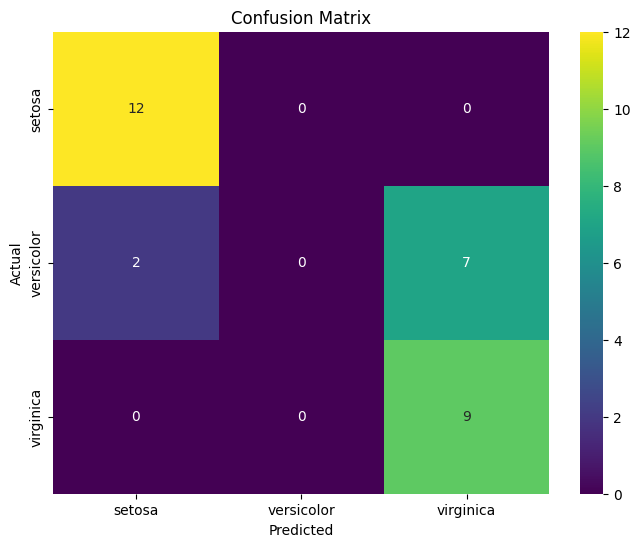


----------------------------------------------------------------------------

Sample 1:
Input: [-0.7647835612297058, 0.399264395236969, -1.0176304578781128, -0.7913368940353394]
Prediction: setosa
Truth: setosa

Sample 2:
Input: [-0.14131870865821838, -0.2787317633628845, 0.5566045045852661, 0.5652406215667725]
Prediction: virginica
Truth: versicolor

Sample 3:
Input: [-0.8894765377044678, -2.5387189388275146, -0.005622267723083496, -0.11304812878370285]
Prediction: setosa
Truth: versicolor

Sample 4:
Input: [0.35745319724082947, 0.6252631545066833, 0.5566045045852661, 0.7008984088897705]
Prediction: virginica
Truth: versicolor

Sample 5:
Input: [0.10806724429130554, -0.956727921962738, 0.33171379566192627, -0.11304812878370285]
Prediction: virginica
Truth: versicolor



<ipython-input-37-9a652778d31a>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(y_test))


In [ ]:
number_of_features=X_train.shape[1]
number_of_classes=len(dataset['target_names'])

model=MLP(number_of_features,number_of_classes)
model,train_loss,valid_loss=train(model,TensorDataset(X_train,y_train),TensorDataset(X_valid,y_valid),3,0.001,4)

evaluate_model_comprehensive(model, X_test, y_test, names, num_samples=5)

1.9) For batch size=4, learning rate=0.001, epochs=5

             Values
Metrics            
Accuracy   0.900000
Precision  0.925000
Recall     0.900000
F1-score   0.897143

----------------------------------------------------------------------------



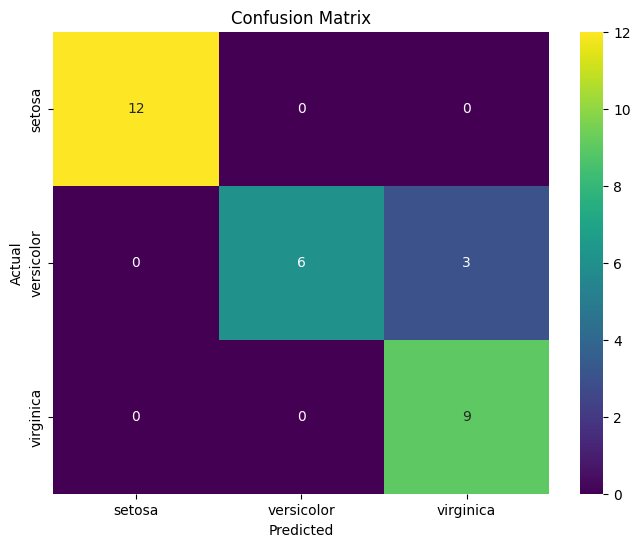


----------------------------------------------------------------------------

Sample 1:
Input: [0.9809180498123169, -0.2787317633628845, 0.9501631855964661, 1.2435294389724731]
Prediction: virginica
Truth: virginica

Sample 2:
Input: [-0.14131870865821838, -1.408725380897522, 0.21926842629909515, 0.02260962501168251]
Prediction: versicolor
Truth: versicolor

Sample 3:
Input: [-0.8894765377044678, -2.5387189388275146, -0.005622267723083496, -0.11304812878370285]
Prediction: versicolor
Truth: versicolor

Sample 4:
Input: [-0.8894765377044678, 0.6252631545066833, -1.0738531351089478, -0.9269946813583374]
Prediction: setosa
Truth: setosa

Sample 5:
Input: [1.2303040027618408, -0.052733033895492554, 1.1750539541244507, 1.7861604690551758]
Prediction: virginica
Truth: virginica



<ipython-input-37-9a652778d31a>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(y_test))


In [ ]:
number_of_features=X_train.shape[1]
number_of_classes=len(dataset['target_names'])

model=MLP(number_of_features,number_of_classes)
model,train_loss,valid_loss=train(model,TensorDataset(X_train,y_train),TensorDataset(X_valid,y_valid),5,0.001,4)

evaluate_model_comprehensive(model, X_test, y_test, names, num_samples=5)

1.10) For batch size=4, learning rate=0.00001, epochs=1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


             Values
Metrics            
Accuracy   0.366667
Precision  0.392308
Recall     0.366667
F1-score   0.287143

----------------------------------------------------------------------------



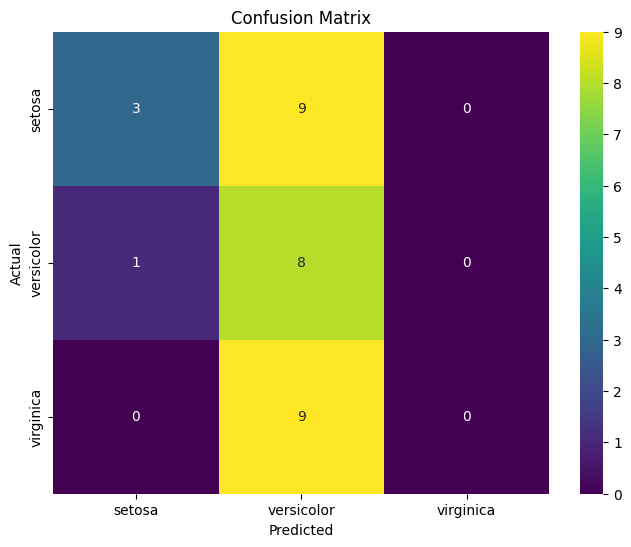


----------------------------------------------------------------------------

Sample 1:
Input: [0.35745319724082947, -0.2787317633628845, 0.725272536277771, 0.9722139239311218]
Prediction: versicolor
Truth: virginica

Sample 2:
Input: [-0.01662573032081127, -1.408725380897522, 0.8377178311347961, 1.2435294389724731]
Prediction: versicolor
Truth: virginica

Sample 3:
Input: [-0.01662573032081127, -0.7307292222976685, 0.5566045045852661, 0.29392513632774353]
Prediction: versicolor
Truth: versicolor

Sample 4:
Input: [-0.8894765377044678, 0.6252631545066833, -1.0738531351089478, -0.9269946813583374]
Prediction: versicolor
Truth: setosa

Sample 5:
Input: [-1.0141695737838745, -0.052733033895492554, -1.1300758123397827, -1.198310136795044]
Prediction: setosa
Truth: setosa



<ipython-input-37-9a652778d31a>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(y_test))


In [ ]:
number_of_features=X_train.shape[1]
number_of_classes=len(dataset['target_names'])

model=MLP(number_of_features,number_of_classes)
model,train_loss,valid_loss=train(model,TensorDataset(X_train,y_train),TensorDataset(X_valid,y_valid),1,0.00001,4)

evaluate_model_comprehensive(model, X_test, y_test, names, num_samples=5)

1.11) For batch size=4, learning rate=0.00001, epochs=3

           Values
Metrics          
Accuracy     0.30
Precision    0.15
Recall       0.30
F1-score     0.20

----------------------------------------------------------------------------



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


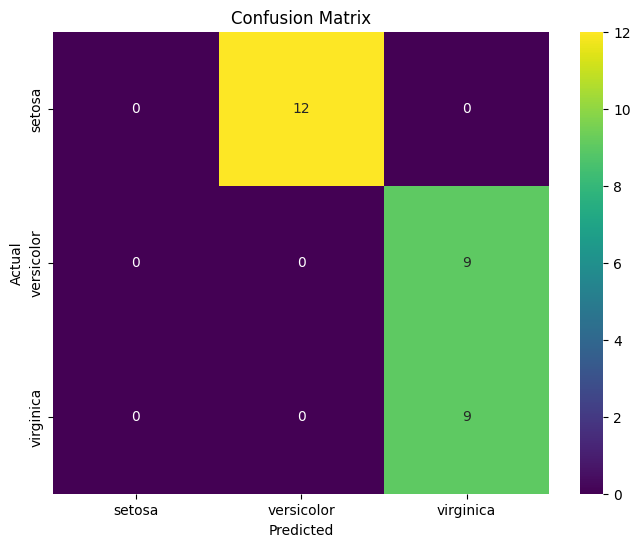


----------------------------------------------------------------------------

Sample 1:
Input: [-0.01662573032081127, -1.408725380897522, 0.8377178311347961, 1.2435294389724731]
Prediction: virginica
Truth: virginica

Sample 2:
Input: [-0.8894765377044678, 0.6252631545066833, -1.0738531351089478, -0.9269946813583374]
Prediction: versicolor
Truth: setosa

Sample 3:
Input: [1.3549970388412476, -0.7307292222976685, 0.725272536277771, 0.4295828938484192]
Prediction: virginica
Truth: versicolor

Sample 4:
Input: [1.2303040027618408, -0.052733033895492554, 1.1750539541244507, 1.7861604690551758]
Prediction: virginica
Truth: virginica

Sample 5:
Input: [0.10806724429130554, -0.956727921962738, 0.33171379566192627, -0.11304812878370285]
Prediction: virginica
Truth: versicolor



<ipython-input-37-9a652778d31a>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(y_test))


In [ ]:
number_of_features=X_train.shape[1]
number_of_classes=len(dataset['target_names'])

model=MLP(number_of_features,number_of_classes)
model,train_loss,valid_loss=train(model,TensorDataset(X_train,y_train),TensorDataset(X_valid,y_valid),3,0.00001,4)

evaluate_model_comprehensive(model, X_test, y_test, names, num_samples=5)

1.12) For batch size=4, learning rate=0.00001, epochs=5

             Values
Metrics            
Accuracy   0.433333
Precision  0.320455
Recall     0.433333
F1-score   0.347249

----------------------------------------------------------------------------



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


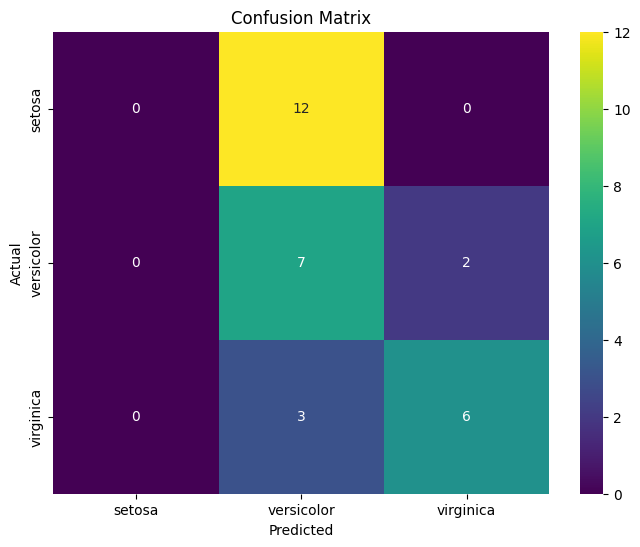


----------------------------------------------------------------------------

Sample 1:
Input: [-0.7647835612297058, 0.399264395236969, -1.0176304578781128, -0.7913368940353394]
Prediction: versicolor
Truth: setosa

Sample 2:
Input: [-0.14131870865821838, -1.408725380897522, 0.21926842629909515, 0.02260962501168251]
Prediction: versicolor
Truth: versicolor

Sample 3:
Input: [0.731532096862793, -0.956727921962738, 0.7814951539039612, 0.9722139239311218]
Prediction: versicolor
Truth: virginica

Sample 4:
Input: [-0.14131870865821838, -0.2787317633628845, 0.5566045045852661, 0.5652406215667725]
Prediction: versicolor
Truth: versicolor

Sample 5:
Input: [-0.01662573032081127, -0.2787317633628845, 0.38793644309043884, 0.15826737880706787]
Prediction: versicolor
Truth: versicolor



<ipython-input-37-9a652778d31a>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = torch.utils.data.TensorDataset(X_test, torch.tensor(y_test))


In [ ]:
number_of_features=X_train.shape[1]
number_of_classes=len(dataset['target_names'])

model=MLP(number_of_features,number_of_classes)
model,train_loss,valid_loss=train(model,TensorDataset(X_train,y_train),TensorDataset(X_valid,y_valid),5,0.00001,4)

evaluate_model_comprehensive(model, X_test, y_test, names, num_samples=5)

In [ ]:
pip install ray

In [ ]:
pip install "ray[tune]"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import ray
from ray import tune
from ray.tune import Tuner
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler
import pandas as pd

# Simulated Dataset (Replace with actual dataset)
X = np.random.rand(1000, 10)  # 1000 samples, 10 features
y = np.random.randint(0, 2, 1000)  # Binary classification

# Split dataset inside function
def load_data():
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.long)
    return X_train, X_val, y_train, y_val

# Define Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.fc(x)

# Training Function
def train_model_tune(config):
    # Load dataset inside function
    X_train, X_val, y_train, y_val = load_data()

    # Convert dataset into DataLoader
    train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=config["batch_size"], shuffle=True)
    val_loader = torch.utils.data.DataLoader(list(zip(X_val, y_val)), batch_size=config["batch_size"], shuffle=False)

    model = SimpleNN(input_size=10, output_size=2)  # Adjust input/output size as needed
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

    for epoch in range(config["epochs"]):
        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.numpy())
            all_labels.extend(targets.numpy())

    accuracy= accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")

    # Report metrics to Ray Tune
    tune.report(accuracy=float(accuracy), f1_score=float(f1))  # Use 'accuracy' and 'f1_score' as metric names

# Define Search Spaces
grid_search_space = {
    "batch_size": tune.grid_search([16, 32, 64]),
    "learning_rate": tune.grid_search([1e-3, 1e-2, 1e-4]),
    "epochs": tune.grid_search([10, 20, 30])
}

random_search_space = {
    "batch_size": tune.choice([16, 32, 64]),
    "learning_rate": tune.loguniform(1e-4, 1e-2),
    "epochs": tune.choice([10, 20, 30])
}

bohb_search_space = {
    "batch_size": tune.randint(16, 64),
    "learning_rate": tune.loguniform(1e-4, 1e-2),
    "epochs": tune.randint(10, 30)
}

# Initialize Ray
ray.init(ignore_reinit_error=True)  # Suppress reinitialization error

# Run Grid Search
grid_tuner = Tuner(
    train_model_tune,
    param_space=grid_search_space,
    tune_config=tune.TuneConfig(
        metric="accuracy",  # Use 'accuracy' as the metric
        mode="max"
    )
)
grid_results = grid_tuner.fit()

# Run Random Search
random_tuner = Tuner(
    train_model_tune,
    param_space=random_search_space,
    tune_config=tune.TuneConfig(
        metric="accuracy",  # Use 'accuracy' as the metric
        mode="max",
        num_samples=10  # Run 10 different trials
    )
)
random_results = random_tuner.fit()

# Run Hyperband Search
hyperband_tuner = Tuner(
    train_model_tune,
    param_space=random_search_space,
    tune_config=tune.TuneConfig(
        metric="accuracy",  # Use 'accuracy' as the metric
        mode="max",
        scheduler=ASHAScheduler(
            max_t=30,  # Max epochs
            grace_period=10,  # Minimum epochs before stopping bad trials
            reduction_factor=2  # Halve the number of trials in each round
        ),
        num_samples=10  # Run 10 different trials
    )
)
hyperband_results = hyperband_tuner.fit()

# Run Bayesian Optimization (BOHB)
bohb_tuner = Tuner(
    train_model_tune,
    param_space=bohb_search_space,
    tune_config=tune.TuneConfig(
        metric="accuracy",  # Use 'accuracy' as the metric
        mode="max",
        search_alg=OptunaSearch(),
        num_samples=10  # Run 10 different trials
    )
)
bohb_results = bohb_tuner.fit()

# Combine Results into DataFrames
def get_results_df(results):
    df = results.get_dataframe()
    return df[["config/batch_size", "config/learning_rate", "config/epochs", "accuracy", "f1_score"]]

grid_df = get_results_df(grid_results)
random_df = get_results_df(random_results)
hyperband_df = get_results_df(hyperband_results)
bohb_df = get_results_df(bohb_results)

# Add Search Method Column
grid_df["Method"] = "Grid Search"
random_df["Method"] = "Random Search"
hyperband_df["Method"] = "Hyperband"
bohb_df["Method"] = "Bayesian Optimization"

# Combine all results
final_results_df = pd.concat([grid_df, random_df, hyperband_df, bohb_df])
print(final_results_df)

2025-02-26 16:26:28,851	INFO worker.py:1672 -- Calling ray.init() again after it has already been called.


+-------------------------------------------------------------------------+
| Configuration for experiment     train_model_tune_2025-02-26_16-26-28   |
+-------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                  |
| Scheduler                        FIFOScheduler                          |
| Number of trials                 27                                     |
+-------------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_model_tune_2025-02-26_16-26-28
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-02-26_15-36-45_146730_149/artifacts/2025-02-26_16-26-28/train_model_tune_2025-02-26_16-26-28/driver_artifacts`

Trial status: 27 PENDING
Current time: 2025-02-26 16:26:29. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+----------------------------------------------------

2025-02-26 16:26:29,506	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-02-26 16:26:29,514	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_tune_2025-02-26_16-26-28' in 0.0072s.
2025-02-26 16:26:29,548	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: Tuner.restore(path="/root/ray_results/train_model_tune_2025-02-26_16-26-28", trainable=...)
2025-02-26 16:26:29,559	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 27 trial(s):
- train_model_tune_6e703_00000: FileNotFoundError('Could not fetch metrics for train_model_tune_6e703_00000: both result.json and progress.csv were not found at /root/ray_results/train_model_tune_2025-02-26_16-26-28/train_model_tune_6e703_00000_

Trial status: 27 PENDING
Current time: 2025-02-26 16:26:29. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------+
| Trial name                     status       batch_size     learning_rate     epochs |
+-------------------------------------------------------------------------------------+
| train_model_tune_6e703_00000   PENDING              16            0.001          10 |
| train_model_tune_6e703_00001   PENDING              32            0.001          10 |
| train_model_tune_6e703_00002   PENDING              64            0.001          10 |
| train_model_tune_6e703_00003   PENDING              16            0.001          20 |
| train_model_tune_6e703_00004   PENDING              32            0.001          20 |
| train_model_tune_6e703_00005   PENDING              64            0.001          20 |
| train_model_tune_6e703_00006   PENDING              16            0.001         

2025-02-26 16:26:30,633	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-02-26 16:26:30,647	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_model_tune_2025-02-26_16-26-29' in 0.0128s.


Trial status: 10 PENDING
Current time: 2025-02-26 16:26:30. Total running time: 1s
Logical resource usage: 1.0/2 CPUs, 0/0 GPUs
+-------------------------------------------------------------------------------------+
| Trial name                     status       batch_size     learning_rate     epochs |
+-------------------------------------------------------------------------------------+
| train_model_tune_6edc4_00000   PENDING              32       0.00106943          20 |
| train_model_tune_6edc4_00001   PENDING              16       0.000270118         10 |
| train_model_tune_6edc4_00002   PENDING              32       0.000487164         30 |
| train_model_tune_6edc4_00003   PENDING              32       0.000257311         30 |
| train_model_tune_6edc4_00004   PENDING              16       0.00110104          20 |
| train_model_tune_6edc4_00005   PENDING              32       0.00892938          10 |
| train_model_tune_6edc4_00006   PENDING              64       0.000511808      

KeyboardInterrupt: 